# Проект e-commerce: вариант 1 
### Испонитель : Сергей Камсарин (https://t.me/KamisarNSK)

In [1]:
# загузка используемых библиотек
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats #для моды
from statistics import mode
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
from datetime import datetime

## ПОСТАНОВКА ЗАДАЧИ:

### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:**

 **1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)**

 **2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)**

 **3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)**

 **4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)** 

 **5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz. (10 баллов)**

 **6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, 
построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти https://guillaume-martin.github.io/rfm-segmentation-with-python.html. (35 баллов)**

#### Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

#### Файлы:
#### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

- **customer_id — позаказный идентификатор пользователя**

- **customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)**

- **customer_zip_code_prefix —  почтовый индекс пользователя**

- **customer_city —  город доставки пользователя**

- **customer_state —  штат доставки пользователя**


#### olist_orders_dataset.csv —  таблица заказов
- **order_id —  уникальный идентификатор заказа (номер чека)**

- **customer_id —  позаказный идентификатор пользователя**

- **order_status —  статус заказа**

- **order_purchase_timestamp —  время создания заказа**

- **order_approved_at —  время подтверждения оплаты заказа**

- **order_delivered_carrier_date —  время передачи заказа в логистическую службу**

- **order_delivered_customer_date —  время доставки заказа**

- **order_estimated_delivery_date —  обещанная дата доставки**


#### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
- **order_id —  уникальный идентификатор заказа (номер чека)**

- **order_item_id —  идентификатор товара внутри одного заказа**

- **product_id —  ид товара (аналог штрихкода)**

- **seller_id — ид производителя товара**

- **shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике**

- **price —  цена за единицу товара**

- **freight_value —  вес товара**

#### — Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

##### Уникальные статусы заказов в таблице olist_orders_dataset:

- **created —  создан**
- **approved —  подтверждён**
- **invoiced —  выставлен счёт**
- **processing —  в процессе сборки заказа**
- **shipped —  отгружен со склада**
- **delivered —  доставлен пользователю**
- **unavailable —  недоступен**
- **canceled —  отменён**

In [2]:
# публичные ссылки на файлы Яндекс.Диск
customers_pk = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
orders_pk = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
items_pk = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [3]:
#Функция для получения загрузочной ссылки
def get_yandex_download_url(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
# Загружаем данные
# таблица с уникальными идентификаторами пользователей
customers = pd.read_csv(get_yandex_download_url(customers_pk))
#  таблица заказов
orders = pd.read_csv(get_yandex_download_url(orders_pk), parse_dates=[3,4,5,6,7])
# товарные позиции, входящие в заказы
items = pd.read_csv(get_yandex_download_url(items_pk), parse_dates=['shipping_limit_date'])

#### Посмотрим на данные(свойства, наличие пропущенных значений)

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


посмотрим нет ли дубликатов?

In [7]:
customers.duplicated().sum()

0

###### в таблице с данными все Ок

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


##### Есть пропущеные значения... в датах( будем иметь ввиду, возможно заказы в стадии выполнения). 
Из описания это: 

- *order_approved_at — время подтверждения оплаты заказа*
- *order_delivered_carrier_date — время передачи заказа в логистическую службу*
- *order_delivered_customer_date — время доставки заказа*
- *order_estimated_delivery_date — обещанная дата доставки*

посмотрим нет ли дубликатов?

In [10]:
orders.duplicated().sum()

0

######  в таблице Дубликатов нет , только пропущенные даты

In [11]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


посмотрим нет ли дубликатов?

In [13]:
items.duplicated().sum()

0

###### в таблице с данными все Ок

таблицы **customers** и **orders** имеют общую колонку **customer_id** (позаказный идентификатор пользователя)

таблицы **items** и **orders** имеют общую колонку **order_id** (уникальный идентификатор заказа (номер чека))

## Задача 1

#### Сколько у нас пользователей, которые совершили покупку только один раз? 

Чтоб определить это число, нужно ввести понятие что считать ***ПОКУПКОЙ*** ?

#### Из энциклопедии по экономике:
**Покупка** — процесс приобретения товара или услуги на рынке, который включает две основные операции обмен и сделку. Это результат приобретения права собственности на интересующие покупателя товар или услугу.

In [14]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


посмотрим на статусы заказов из таблицы ***orders***(таблица заказов)

In [15]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

- **delivered —  доставлен пользователю**
- **shipped —  отгружен со склада**
- **canceled —  отменён**
- **unavailable —  недоступен**
- **invoiced —  выставлен счёт**
- **processing —  в процессе сборки заказа**
- **created —  создан**
- **approved —  подтверждён**


по рекомендации из постановки задачи посмотрим на заказ **order_id == 00143d0f86d6fbd9f9b38ab440ac16f5**

In [16]:
sample = orders.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')
sample

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


##### заказ идет в хронологической последовательности:
   - *создания заказа/   подтверждения оплаты заказа/    передача заказа в логистическую службу/    доставка заказа*

##### Посмотроим на статусы заказов где указано время оплаты

In [17]:
orders.loc[pd.isna(orders.order_approved_at) == False].order_status.value_counts()

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

##### Посмотроим на статусы заказов где указано время передачи товара в ТК

In [18]:
orders.loc[pd.isna(orders.order_delivered_carrier_date) == False].order_status.value_counts()

delivered    96476
shipped       1107
canceled        75
Name: order_status, dtype: int64

##### Посмотроим на статусы заказов где нет времени оплаты

In [19]:
orders.loc[pd.isna(orders.order_approved_at)].order_status.value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

странно ... есть 14  заказов  со статусом **delivered — доставлен пользователю** но нет даты оплаты

##### Посмотроим на статусы заказов где нет времени передачи товара в ТК

In [20]:
orders.loc[pd.isna(orders.order_delivered_carrier_date)].order_status.value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
delivered        2
approved         2
Name: order_status, dtype: int64

Так кау у нас процесс покупки занимает какой-то длительный период времени

( не как в обычном магазине положил деньги на прилавок/забрал тут же товар ) 

и  могут возникнуть факторы которые помешают завершению процесса покупки(нет достаточного количества(продавец значит не сможет выполнить обязательства и соответсвенно должен вернуть деньги)) либо покупатель пока еще "не забрал товар с прилавка" увидел другой ) и решил изменить выбор и.тп...

Будем считать ***ПОКУПКОЙ*** только те заказы у которых есть 

**время подтверждения оплаты заказа**  order_approved_at , т.е. ***ОПЛАЧЕНЫЕ ЗАКАЗЫ***  И 

статус заказаза **НЕ "canceled"** т.е. **сделка в процессе выполнения** и должна завершится.

**Датой покупки** - будем считать дату оплаты(начало процесса) **ДАТА на чеке**



- **с позиции бухгалтерии:**

(как только денежные средства поступили на расчетный счет (или в кассу организации) покупателю выдается чек, дополнительно в РФ еще дублируюся данные онлайн кассой где все поступления денег фиксируются и сразу передаются данные в соответствующие органы для контроля расчета уплаты налога, если же клиент впоследствии ( по каким-то обоснованым( к примеру по закону РФ есть 14 дней для возврата товара для определенных групп товаров без обьяснения причин) причинам отказался от покупки то ему оформляют ВОЗВРАТ ПОКУПКИ, и так же все фиксируется в онлайн кассе. (также возможна отмена покупки в течении рабочей смены кассы тогда просто идет возврат средств и это тоже фиксируется)

- **с позиции логики**

(пока продавец не получил денежный эквивалент за свой товар, товар пренадлежит продавцу(независимо где товар находится). И соответственно если покупатель оплатил за товар, то товар уже его(независимо где товар находится)
- **с позиции классики )**

"Согласие есть продукт при полном непротивлении сторон."
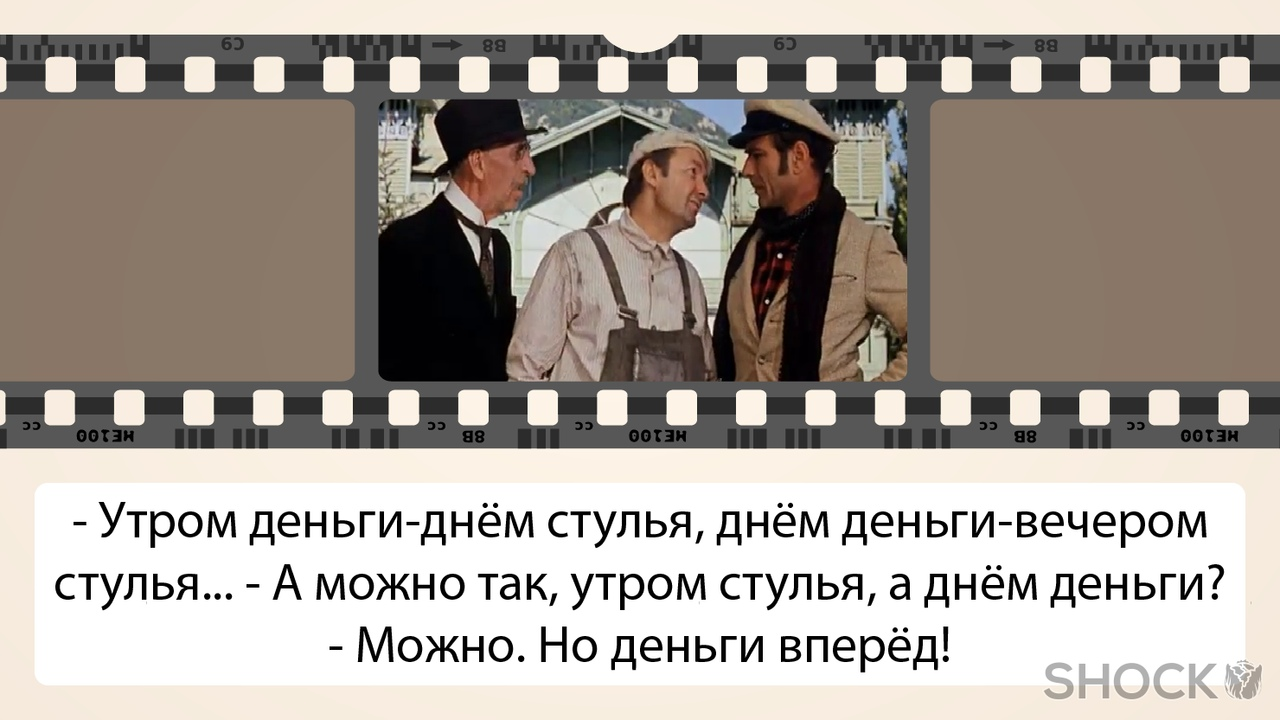

Значит Всего покупок(**purchase**) **совершенных сделок** отбираем из **orders** где есть время оплаты и нет статуса **"canceled"**

In [21]:
purchase = orders\
    .loc[pd.isna(orders.order_approved_at) == False]\
    .query('order_status not in "canceled"')
purchase.shape[0]

98797

Обьеденим таблицы **purchase** (таблица заказов где только покупки) и **customers** (таблица с уникальными идентификаторами пользователей) по колонке **customer_id**  в  **purchase_with_customers**

In [22]:
purchase_with_customers = pd.merge(purchase, customers, on = 'customer_id' )
purchase_with_customers.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


групируем по уникальным покупателям и смотрим количество покупок

In [23]:
purchase_with_customers.groupby('customer_unique_id', as_index=False) \
                        .agg({'order_id': 'count'}).order_id.value_counts()


1     92621
2      2686
3       187
4        30
5         8
6         6
7         3
17        1
9         1
Name: order_id, dtype: int64

##### ОТВЕТ на Вопрос "Сколько у нас пользователей, которые совершили покупку только один раз? "

### У нас 92621 пользователей, которые совершили покупку только один раз

## Задача 2

#### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

отберем сначала данные из таблицы ***orders***(таблица заказов) где нет статуса **delivered** (доставлен пользователю)

И сохраним в новую таблицу **orders_no_delivered**

In [24]:
orders_no_delivered = orders.query("order_status != 'delivered'")
orders_no_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


переведем дату создания заказа в индекс для удобства дальнейших групировок

In [25]:
orders_no_delivered_by_month = orders_no_delivered.set_index('order_purchase_timestamp')\
                                                .sort_values('order_purchase_timestamp') 
orders_no_delivered_by_month.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,
2016-09-04 21:15:19,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20
2016-09-05 00:15:34,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-10-07 13:17:15,NaT,NaT,2016-10-28
2016-09-13 15:24:19,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-10-07 13:16:46,NaT,NaT,2016-09-30
2016-10-02 22:07:52,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-06 15:50:56,NaT,NaT,2016-10-25
2016-10-03 21:01:41,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25


групируем по месяцам и смотрим сколько **"недоставленных"** в каждый месяц

In [26]:
# подкорректируем размер выводимых графиков
sns.set(font_scale =1, style ="whitegrid", rc ={'figure.figsize':(20,7)})

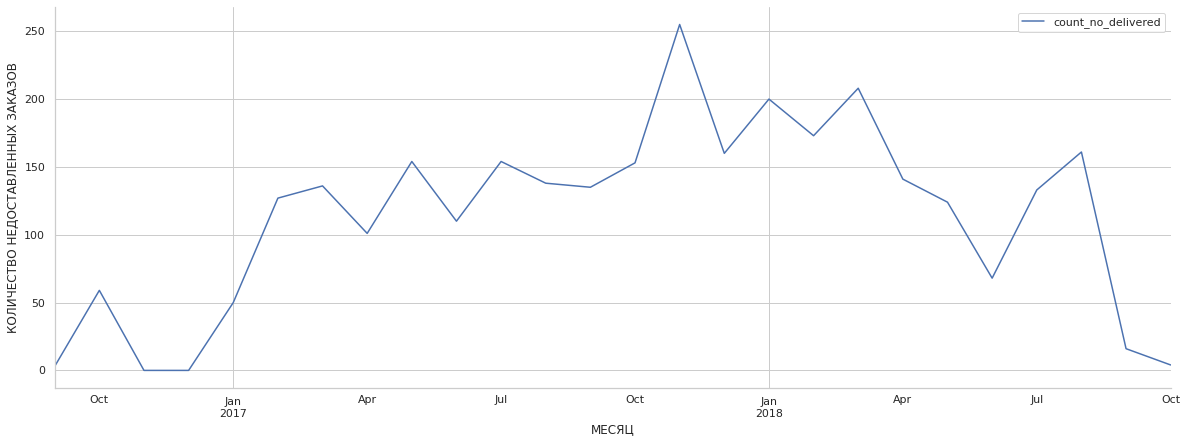

In [27]:
orders_no_delivered_by_month_count = orders_no_delivered_by_month.resample(rule="M") \
                            .agg({'order_status':'count'}) \
                            .rename(columns={'order_status':'count_no_delivered'})
orders_no_delivered_by_month_count.plot()

plt.xlabel('МЕСЯЦ')
plt.ylabel('КОЛИЧЕСТВО НЕДОСТАВЛЕННЫХ ЗАКАЗОВ')
sns.despine()

Посмотрим на цифры( среднее/медиана)

In [28]:
orders_no_delivered_by_month_count.describe()

,count_no_delivered
count,26.000000
mean,113.961538
std,69.552559
min,0.000000
25%,61.250000
50%,134.000000
75%,154.000000
max,255.000000


посмотрим какие в основном статусы у **"Недоставленных"** товаров

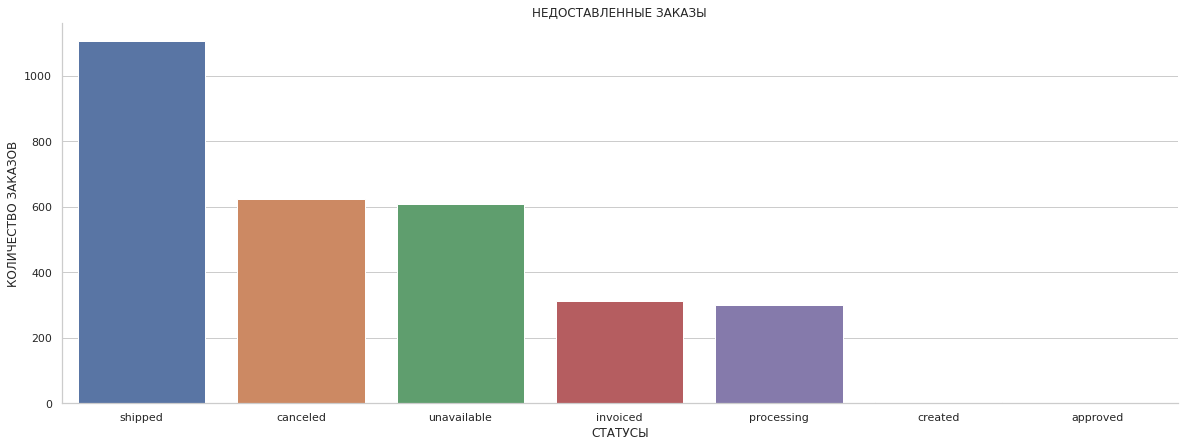

In [29]:
status = orders_no_delivered_by_month.groupby('order_status', as_index = False) \
                 .agg({'order_id' : 'count'}) \
                 .sort_values('order_id', ascending = False)\
                 .rename(columns={'order_id' : 'orders_count'})                           
sns.barplot(x='order_status',y='orders_count',data=status)
plt.title('НЕДОСТАВЛЕННЫЕ ЗАКАЗЫ')
plt.xlabel('СТАТУСЫ')
plt.ylabel('КОЛИЧЕСТВО ЗАКАЗОВ')
sns.despine()


посмотрим на количество "недоставленных" 

In [30]:
orders_no_delivered.order_status.value_counts()

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

In [31]:
#  странный статус ... надо проверить
need_analysis = orders_no_delivered_by_month.query('order_status == "unavailable"')
need_analysis.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,
2016-10-05 14:16:28,dc18a044b56ed174037ca164cdf2e921,4a06381959b6670756de02e07b83815f,unavailable,2016-10-06 15:56:49,NaT,NaT,2016-11-29
2016-10-05 17:21:29,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-06 15:55:40,NaT,NaT,2016-11-29
2016-10-05 18:06:48,1612081119e8f23745698ad3367cc14b,20d32833d8983a835cafcd54099631a0,unavailable,2017-04-11 15:17:38,NaT,NaT,2016-11-17
2016-10-06 13:38:39,54bb06e1ca86bd99ee2a8d6288bf4ede,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 14:22:19,NaT,NaT,2016-12-12
2016-10-06 23:49:18,4dd47e84e6b8ff4a63d0b8425e6d788e,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-07 01:09:08,NaT,NaT,2016-11-24


##### ОТВЕТ на Вопрос "Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?"

### В среднем (арифметически) в месяц по РАЗНЫМ причинам не доставляется 114  заказов. Но наверно здесь будет более уместно медианное среднее оно равно 134 заказам.
Но часть заказов **shipped**   еще в стадии доставки, **canceled** отмененные заказы и не нужно доставлять, **processing** 

будет отправлено после сборки, **invoiced** скорее всего не оплачен (можно потревожить клиента и напомнить), обратить внимание

надо на заказы со статусом **unavailable** недоступен (отсортированы в **need_analysis**)

## Задача 3

#### По каждому товару определить, в какой день недели товар чаще всего покупается.

обьеденим таблицу заказов с **покупками** (которую мы сделали ранее(где только  покупки)) и таблицу с товарными позициями, входящие в заказы, по колонке **order_id** уникальный идентификатор заказа (номер чека)

создадим дополнительно колонку с днем недели(когда заказ был оплачен(т.е. покупатель подтвердил свои намерения)), сгрупируем по наименованию товаров

и найдем какие дни для этого товара встречаются больше всего в покупках(чеках)

In [32]:
# обьединяем, добавляем колонку
better_day = pd.merge(purchase, items, how='left', on = 'order_id' )
better_day['day_of_the_week'] = better_day['order_approved_at'].dt.day_name()
better_day.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_the_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [33]:
better_day.duplicated(['order_id','product_id']).sum()

10147

###### в нашей таблице сейчас есть дубликаты если один и тот же продукт встречался в одном заказе несколько раз. 
У нас же задача поставлена найти частоту а не максимальное количество.

т.е. если к  примеру один и тотже товар продавался по 1 шт по понедельникам -10 раз ( всего продано 10 шт)

а какой-то оптовик взял и в субботу купил 100 шт за раз. но чаще выходит продавалось по понедельникам ) хоть и меньше

удалим повторяющиеся позиции в чеке

In [34]:
better_day_no_duplicat = better_day.drop_duplicates(['order_id','product_id'], keep = 'first')
better_day_no_duplicat

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_the_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112693,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,2017-03-15 09:54:05,72.00,13.08,Thursday
112694,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,Tuesday
112695,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,Sunday
112696,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday


In [35]:
# Групируем
the_best_day = better_day_no_duplicat\
                .groupby(['product_id', 'day_of_the_week'], as_index = False)\
                .agg({'order_id':'count'})\
                .rename(columns={'order_id':'count_order_id'})

the_best_day

,product_id,day_of_the_week,count_order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
60794,fff9553ac224cec9d15d49f5a263411f,Saturday,1
60795,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
60796,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
60797,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3


In [36]:
# сделаем транспонирование таблицы
the_best_days = the_best_day.pivot(index='product_id', columns='day_of_the_week', values='count_order_id')\
            .reindex(columns =['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'])
the_best_days

day_of_the_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,NaN,NaN,NaN,1.0
00088930e925c41fd95ebfe695fd2655,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN
000b8f95fcb9e0096488278317764d19,NaN,NaN,1.0,NaN,1.0,NaN,NaN
000d9be29b5207b54e86aa1b1ac54872,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,1.0,NaN,NaN,NaN,NaN,1.0,NaN
fff81cc3158d2725c0655ab9ba0f712c,1.0,NaN,NaN,NaN,NaN,NaN,NaN
fff9553ac224cec9d15d49f5a263411f,NaN,NaN,NaN,NaN,NaN,1.0,NaN


###### смотрим на таблицу .. и не понятно если всего 2 раза товар покупался ... какой из дней считать нужным нам ?)

In [37]:
# Посмотрим какие дни в принципе самые частые при совершении покупок
the_best_days.describe()

day_of_the_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
count,8274.000000,10826.000000,9411.000000,9302.000000,9010.000000,7806.000000,6170.000000
mean,1.615905,1.819416,1.713952,1.707160,1.671143,1.608378,1.500324
std,2.246056,3.190951,2.725328,2.653893,2.596620,2.326017,1.790924
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,70.000000,97.000000,74.000000,66.000000,77.000000,68.000000,51.000000


и самый лучший день выходит Вторник) **Tuesday**

###### Все-таки лучше выделить все дни в которые чаще всего делалась покупка товара(если количество покупок одинаково)

In [38]:
best_days = better_day_no_duplicat.groupby('product_id').day_of_the_week\
            .agg(lambda x : x.mode()[:])\
            .reset_index()\
            .rename(columns={'day_of_the_week':'Best_days_of_the_week'})

best_days

,product_id,Best_days_of_the_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32727,fff6177642830a9a94a0f2cba5e476d1,"[Monday, Saturday]"
32728,fff81cc3158d2725c0655ab9ba0f712c,Monday
32729,fff9553ac224cec9d15d49f5a263411f,Saturday
32730,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


##### ОТВЕТ на Вопрос: По каждому товару определить, в какой день недели товар чаще всего покупается

### В таблице (best_days) преречислены  товары с чаще встречающимся днями его покупки.. 

НО если таких дней несколько( с одинаково часто встречающимся числом покупок) через запятую указаны все эти дни

## Задача 4

####  Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

Воспользуемся нашей таблицей **purchase_with_customers** где обьеденены таблицы **purchase** (таблица заказов где только покупки) и **customers** (таблица с уникальными идентификаторами пользователей) по колонке **customer_id** 

In [39]:
purchase_with_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


создадим копию **purchase_customers_by_month** (вдруг оригинал еще потребуется) только с теми колонками которые нам потребуются сейчас

In [40]:
purchase_customers_by_month = purchase_with_customers[['order_id', 'customer_unique_id', 'order_approved_at']]

добавим колонку **year_month** - год и месяц , **month** название месяца 

и колонку **week_of_month** сколько в этом месяце года недель(количество дней /7) за основу берем дату оплаты (начала сделки)

In [41]:
purchase_customers_by_month['year_month'] = purchase_customers_by_month['order_approved_at'].dt.strftime('%Y-%m')
# это отдельно колонка месяца чтоб взять среднее по годам
purchase_customers_by_month['month'] = purchase_customers_by_month['order_approved_at'].dt.month_name()
purchase_customers_by_month['week_of_month'] = purchase_customers_by_month['order_approved_at'].dt.daysinmonth/7
# игнорируем лишние колонки для удобства
purchase_by_month = purchase_customers_by_month[['order_id', 'customer_unique_id', 'year_month','week_of_month','month']]

purchase_by_month

,order_id,customer_unique_id,year_month,week_of_month,month
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10,4.428571,October
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07,4.428571,July
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,4.428571,August
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11,4.285714,November
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,4.000000,February
...,...,...,...,...,...
98792,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,4.428571,March
98793,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02,4.000000,February
98794,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08,4.428571,August
98795,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01,4.428571,January


Групируем по **customer_unique_id и year_month** считаем количество покупок для каждой недели каждого месяца каждого года

In [42]:
# Групируем по customer_unique_id и year_month считаем количество покупок для каждой недели каждого месяца каждого года
purchase_by_week = purchase_by_month.groupby(['customer_unique_id','year_month','week_of_month','month'],as_index=False)\
            .agg({'order_id':'count'})\
            .rename(columns={'order_id':'order_month'})\
            .sort_values('year_month')
purchase_by_week['order_week'] = purchase_by_week.order_month/purchase_by_week.week_of_month

purchase_by_week 

,customer_unique_id,year_month,week_of_month,month,order_month,order_week
49995,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09,4.285714,September,1,0.233333
49788,827e0258c06b6c4bfecec9e54bc04960,2016-10,4.428571,October,1,0.225806
16328,2ad9e4ed11e15401527b7e30080ce45f,2016-10,4.428571,October,1,0.225806
44882,75b181fe0ef694c753c72540c0fdd389,2016-10,4.428571,October,1,0.225806
16306,2ad10f49ef1f061d5f6739c89d3ade68,2016-10,4.428571,October,1,0.225806
...,...,...,...,...,...,...
51909,8850bcaf8541216fa9c321f189af8031,2018-08,4.428571,August,1,0.225806
26988,46b44ab325f78e5bb3dc0bbef1082082,2018-08,4.428571,August,1,0.225806
5839,0f4445cc3c0c9d9f171bb06276bf8628,2018-08,4.428571,August,1,0.225806
10931,1c78cc523e89a9c1d0beef9598566562,2018-08,4.428571,August,1,0.225806


#### Получили информацию за несколько лет . Сколько у каждого пользователя в определенный месяц определенного года в среднем покупок в неделю. Но может нужна информация более обобщеная ? среднее всех лет?

убререм уже не нужные столбцы для дальнейшего удобства агрегации

In [43]:
purchase_by_week_mean  =  purchase_by_week[['customer_unique_id', 'month', 'order_week']] 
purchase_by_week_mean

,customer_unique_id,month,order_week
49995,830d5b7aaa3b6f1e9ad63703bec97d23,September,0.233333
49788,827e0258c06b6c4bfecec9e54bc04960,October,0.225806
16328,2ad9e4ed11e15401527b7e30080ce45f,October,0.225806
44882,75b181fe0ef694c753c72540c0fdd389,October,0.225806
16306,2ad10f49ef1f061d5f6739c89d3ade68,October,0.225806
...,...,...,...
51909,8850bcaf8541216fa9c321f189af8031,August,0.225806
26988,46b44ab325f78e5bb3dc0bbef1082082,August,0.225806
5839,0f4445cc3c0c9d9f171bb06276bf8628,August,0.225806
10931,1c78cc523e89a9c1d0beef9598566562,August,0.225806


Возьмем среднее по месяцам НЕЗАВИСИМО от года

In [44]:
purchase_by_week_mean = purchase_by_week_mean\
            .groupby(['customer_unique_id','month'],as_index=False)\
            .agg({'order_week':'mean'})\
            .rename(columns={'order_week':'mean_week'})
purchase_by_week_mean

,customer_unique_id,month,mean_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,0.225806
2,0000f46a3911fa3c0805444483337064,March,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,October,0.225806
4,0004aac84e0df4da2b147fca70cf8255,November,0.233333
...,...,...,...
97388,fffcf5a5ff07b0908bd4e2dbc735a684,June,0.233333
97389,fffea47cd6d3cc0a88bd621562a9d061,December,0.225806
97390,ffff371b4d645b6ecea244b27531430a,February,0.250000
97391,ffff5962728ec6157033ef9805bacc48,May,0.225806


##### ВРОДЕ ВОТ ОН ответ? но давайте еще улучшим восприятие данных

In [45]:
# сделаем транспонирование таблицы
best_purchase_by_week_mean = purchase_by_week_mean\
        .pivot(index='customer_unique_id', columns='month', values='mean_week')\
        .reindex(columns =['January','February', 'March', 'April', 'May'\
        ,'June', 'July', 'August', 'September', 'October','November','December'])
best_purchase_by_week_mean

month,January,February,March,April,May,June,July,August,September,October,November,December
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,NaN,NaN,NaN,0.225806,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000f46a3911fa3c0805444483337064,NaN,NaN,0.225806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000f6ccb0745a6a4b88665a16c9f078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.225806,NaN,NaN
0004aac84e0df4da2b147fca70cf8255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN,NaN,NaN,NaN,NaN,0.233333,NaN,NaN,NaN,NaN,NaN,NaN
fffea47cd6d3cc0a88bd621562a9d061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.225806
ffff371b4d645b6ecea244b27531430a,NaN,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### ОТВЕТ на Вопрос:  Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

### В таблице ( purchase_by_week ) Перечислено  сколько у каждого пользователя в определенный месяц определенного года в среднем покупок в неделю

### В таблицах ( purchase_by_week и   best_purchase_by_week_mean ) уже обобщеная информация
(усредненная по годам)


## Задача 5

### Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz. 

### Ну для тех кто не знал ) или забыл:

**Retention rate** (он же customer retention rate или **RR**, или **коэффициент удержания клиентов**) — это процент клиентов, которых компания удерживает в течение определенного периода времени. Иначе говоря, коэффициент удержания представляет собой процент постоянных покупателей, лояльных компании. 

#### Что нужно для когортного анализа?
Перед проведением когортного анализа определяют четыре параметра:

- **Признак формирования когорты — действие, которое объединяет людей в группу: первый визит, покупка, установка, регистрация и т.п.**
- **Размер когорты — временной интервал: день, неделя, месяц.**
- **Отчетный период — время исследования поведения групп.**
- **Анализируемый ключевой показатель: ROI, Retention Rate, LTV и т.д.**

### У нас будет:
- **Признак формирования когорты - первая покупка (дата оплаты)**
- **Размер когорты —  месяц**
- **Отчетный период - 12 месяцев(один год)**
- **Анализируемый ключевой показатель: Retention**

Воспользуемся нашей таблицей **purchase_with_customers** где обьеденены таблицы purchase (таблица заказов где только покупки) и customers (таблица с уникальными идентификаторами пользователей) по колонке customer_id

In [46]:
purchase_with_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


Возьмем нужные нам колонки, сохраним  в **purchase_for_cagort** добавим колонку **year_month** - год и месяц покупки

In [47]:
purchase_for_cagort = purchase_with_customers[['order_id','customer_unique_id', 'order_approved_at']]
purchase_for_cagort['year_month'] = purchase_for_cagort['order_approved_at'].dt.strftime('%Y-%m')
purchase_for_cagort

,order_id,customer_unique_id,order_approved_at,year_month
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02
...,...,...,...,...
98792,9c5dedf39a927c1b2549525ed64a053c,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-03
98793,63943bddc261676b46f01ca7ac2f7bd8,da62f9e57a76d978d02ab5362c509660,2018-02-06 13:10:37,2018-02
98794,83c1379a015df1e13d02aae0204711ab,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 15:04:16,2017-08
98795,11c177c8e97725db2631073c19f07b62,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:36:21,2018-01


Создадим новый столбец **CohortGroup**, который является годом и месяцем, когда произошла первая покупка клиента.

In [48]:
purchase_for_cagort.set_index('customer_unique_id', inplace=True)
purchase_for_cagort['CohortGroup'] = purchase_for_cagort\
            .groupby(level=0)['order_approved_at'].min().dt.strftime('%Y-%m')
purchase_for_cagort.reset_index(inplace=True)

In [49]:
purchase_for_cagort.head()

,customer_unique_id,order_id,order_approved_at,year_month,CohortGroup
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,2018-02,2018-02


Рассматриваем ежемесячные когорты, нам необходимо агрегировать клиентов, покупки 
по каждой **CohortGroup** в течение месяца **year_month**.

In [50]:
grouped = purchase_for_cagort.groupby(['CohortGroup', 'year_month'])
cohorts = grouped.agg({'customer_unique_id': pd.Series.nunique,
                        'order_id': 'count'})
cohorts.rename(columns={'customer_unique_id': 'TotalClients',
                         'order_id': 'TotalOrders'}, inplace=True)

In [51]:
cohorts.head()

TotalClients  TotalOrders
CohortGroup year_month                           
2016-09     2016-09                1            1
2016-10     2016-10              297          300
            2017-04                1            1
            2017-07                1            1
            2017-09                1            1

###### Мы хотим посмотреть, как каждая когорта вела себя в течение нескольких месяцев после их первой покупки, 

поэтому нам нужно будет проиндексировать каждую когорту 

0 – когда пользователи только-только сделали первую покупку.

Далее – сколько из них сделали покупку в 1 месяце, 2, ..., 12-м. 

Часть значений остается пропущенной, поскольку период наблюдений для части пользователей меньше, чем для остальных.

Это позволяет нам сравнивать когорты на разных этапах их жизни.

In [52]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df))
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts


TotalClients  TotalOrders  CohortPeriod
CohortGroup year_month                                         
2016-09     2016-09                1            1             0
2016-10     2016-10              297          300             0
            2017-04                1            1             1
            2017-07                1            1             2
            2017-09                1            1             3
...                              ...          ...           ...
2018-06     2018-08               16           17             2
2018-07     2018-07             5926         5985             0
            2018-08               30           30             1
2018-08     2018-08             6368         6407             0
            2018-09                1            1             1

[220 rows x 3 columns]

In [53]:
# Ограничим Отчетный период
cohorts_year = cohorts.query('CohortPeriod < 13')
cohorts_year.reset_index(inplace=True)
cohorts_year.set_index(['CohortPeriod', 'CohortGroup'], inplace=True)
cohorts_year


year_month  TotalClients  TotalOrders
CohortPeriod CohortGroup                                      
0            2016-09        2016-09             1            1
             2016-10        2016-10           297          300
1            2016-10        2017-04             1            1
2            2016-10        2017-07             1            1
3            2016-10        2017-09             1            1
...                             ...           ...          ...
2            2018-06        2018-08            16           17
0            2018-07        2018-07          5926         5985
1            2018-07        2018-08            30           30
0            2018-08        2018-08          6368         6407
1            2018-08        2018-09             1            1

[195 rows x 3 columns]

In [54]:
cohort_group = cohorts_year['TotalClients'].groupby(level=1).first()
cohorts_year['TotalClients'].unstack(0)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortGroup,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,297.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,724.0,4.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,2.0,2.0,6.0,3.0
2017-02,1721.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,5.0,3.0
2017-03,2612.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,4.0,6.0
2017-04,2310.0,14.0,5.0,4.0,6.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,2.0
2017-05,3574.0,19.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,10.0,10.0,12.0,7.0
2017-06,3134.0,14.0,11.0,13.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,11.0,5.0


In [55]:
# Посчитаем количесво уникальных покупателей (кто совершил хоть 1 покупку) ничего вернее никого не потеряли)
cohort_group.sum()

95543

In [56]:
retention_rate = cohorts_year['TotalClients'].unstack(0).divide(cohort_group, axis=0)
retention_rate

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortGroup,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.003367,0.003367,0.003367,0.003367,0.003367,0.003367,0.006734,0.006734,NaN,NaN,NaN,NaN
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.005525,0.002762,0.001381,0.004144,0.001381,0.005525,0.001381,0.001381,0.002762,0.002762,0.008287,0.004144
2017-02,1.0,0.002324,0.002324,0.001743,0.004067,0.001162,0.002324,0.001743,0.001162,0.002324,0.001162,0.002905,0.001743
2017-03,1.0,0.004977,0.003446,0.003446,0.003446,0.001531,0.001531,0.003063,0.003063,0.001149,0.003828,0.001531,0.002297
2017-04,1.0,0.006061,0.002165,0.001732,0.002597,0.002597,0.003463,0.002597,0.003463,0.001732,0.002165,0.000866,0.000866
2017-05,1.0,0.005316,0.005036,0.003917,0.003078,0.003358,0.004197,0.001679,0.002518,0.002798,0.002798,0.003358,0.001959
2017-06,1.0,0.004467,0.003510,0.004148,0.002553,0.003510,0.003510,0.002234,0.001276,0.002234,0.003191,0.003510,0.001595


In [57]:
cohort_analysis = (retention_rate
            .style            
            .set_caption('Retention(Удержание пользователей по когортам(месяц первой покупки(оплата товара))') 
            .background_gradient(cmap='summer')
            .highlight_null('white')              
            .format("{:.2%}", na_rep=""))
cohort_analysis

# cmap='icefire' (другой вариант цветовой гаммы) если summer "летний"  не нравится))

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortGroup,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,
2016-10,100.00%,0.34%,0.34%,0.34%,0.34%,0.34%,0.34%,0.67%,0.67%,,,,
2016-12,100.00%,100.00%,,,,,,,,,,,
2017-01,100.00%,0.55%,0.28%,0.14%,0.41%,0.14%,0.55%,0.14%,0.14%,0.28%,0.28%,0.83%,0.41%
2017-02,100.00%,0.23%,0.23%,0.17%,0.41%,0.12%,0.23%,0.17%,0.12%,0.23%,0.12%,0.29%,0.17%
2017-03,100.00%,0.50%,0.34%,0.34%,0.34%,0.15%,0.15%,0.31%,0.31%,0.11%,0.38%,0.15%,0.23%
2017-04,100.00%,0.61%,0.22%,0.17%,0.26%,0.26%,0.35%,0.26%,0.35%,0.17%,0.22%,0.09%,0.09%
2017-05,100.00%,0.53%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,0.25%,0.28%,0.28%,0.34%,0.20%
2017-06,100.00%,0.45%,0.35%,0.41%,0.26%,0.35%,0.35%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%


##### ОТВЕТ на Вопрос: "Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц"

### На 3й месяц Retention(коэффициент удержания клиентов)  максимален у кагорты **2017-06** и равен **0.41%**

## Задача 6

### Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:
- R - время от последней покупки пользователя до текущей даты, 

- F - суммарное количество покупок у пользователя за всё время, 

- M - сумма покупок за всё время. 

Подробно опиши, как ты создавал кластеры. 

**Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.** 

Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней,

frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

Описание подхода можно найти https://guillaume-martin.github.io/rfm-segmentation-with-python.html.

### для решения поставленной задачи

Возьмем **items**(товарные позиции, входящие в заказы) и поститаем сумму каждого заказа в **order_amount**

In [58]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [59]:
#поссмотрим на уникальные значения
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [60]:
# сумма всех созданных заказов
items.price.sum()

13591643.700000003

In [61]:
order_amount = items.groupby('order_id', as_index = False)\
            .agg({'price':'sum'})\
            .rename(columns={'price':'amount'})
order_amount

,order_id,amount
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


Воспользуемся нашей таблицей **purchase_with_customers** где обьеденены таблицы purchase (таблица заказов где только покупки) и customers (таблица с уникальными идентификаторами пользователей) по колонке customer_id и обьеденим с таблицей **order_amount**

In [62]:
purchase_with_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [63]:
purchase_with_customers.nunique()

order_id                         98797
customer_id                      98797
order_status                         6
order_purchase_timestamp         98238
order_approved_at                90301
order_delivered_carrier_date     80939
order_delivered_customer_date    95644
order_estimated_delivery_date      448
customer_unique_id               95543
customer_zip_code_prefix         14982
customer_city                     4117
customer_state                      27
dtype: int64

###### Странно но количество заказов больше количества сумм заказов, проверим

In [64]:
order_custmores_amount = pd.merge(purchase_with_customers, order_amount, how='left', on = 'order_id' )
order_custmores_amount.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,amount
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,19.90


In [65]:
order_custmores_amount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98797 entries, 0 to 98796
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98797 non-null  object        
 1   customer_id                    98797 non-null  object        
 2   order_status                   98797 non-null  object        
 3   order_purchase_timestamp       98797 non-null  datetime64[ns]
 4   order_approved_at              98797 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97569 non-null  datetime64[ns]
 6   order_delivered_customer_date  96456 non-null  datetime64[ns]
 7   order_estimated_delivery_date  98797 non-null  datetime64[ns]
 8   customer_unique_id             98797 non-null  object        
 9   customer_zip_code_prefix       98797 non-null  int64         
 10  customer_city                  98797 non-null  object        
 11  customer_state 

посмотрим на статусы этих заказов( у которых нет сумм заказов)

In [66]:
order_custmores_amount.loc[pd.isna(order_custmores_amount.amount) == True].order_status.value_counts()


unavailable    603
invoiced         2
shipped          1
Name: order_status, dtype: int64

в основном **unavailable  недоступен** может они и отменены или др.причины(человеческий фактор - ошибка) уберем данные заказы для решения поставленной задачи (можно было соеденять таблицы изначально по полному соответсвию **inner** но интересно было проверить) 

P.S. **ВАСИЛИЙ** надо обязательно проверить что с этими заказами ведь оплата написано поступила!

возмем нужные колонки для удобства

In [67]:
order_custmores_amount = order_custmores_amount.loc[pd.isna(order_custmores_amount.amount) == False]
order_custmores_amount = order_custmores_amount[['order_id','customer_unique_id','order_approved_at','amount']]
order_custmores_amount.head()

,order_id,customer_unique_id,order_approved_at,amount
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,19.90


Я собираюсь изучить данные за весь период времени которвые у нас есть

Рассчитайте недавность, частоту и денежную стоимость каждого клиента
Чтобы упростить задачу, я собираюсь добавить столбец с количеством дней между покупкой и текущим моментом. Чтобы найти значения новизны, мне просто нужно найти минимум этого столбца для каждого клиента.

Чтобы упростить задачу, я собираюсь добавить столбец с количеством дней между покупкой и текущим моментом. Чтобы найти значения новизны, мне просто нужно найти минимум этого столбца для каждого клиента.

# Приступим..

- Recency — разница между текущей датой и датой последнего платежа (чем этот показатель ниже, тем нам лучше)
- Frequency — количество покупок
- Monetary — сумма покупок

Эти три показателя нужно рассчитать отдельно для каждого покупателя. После чего поставить оценки от 1-3 или  1-5 посмотрим на наши данные . Чем шире диапазон, тем более узкие сегменты у нас получатся.

Так как датасет не самый свежий, вместо текущей даты будем использовать **last_date** дату на один день после последней покупки. 

Эта дата будет использоваться в качестве ссылки для расчета Recency оценки. Для создания recency, frequency и monetary мы сгруппируем наши записи по customer_unique_id.

In [68]:
last_date = order_custmores_amount['order_approved_at'].max() + timedelta(days=1)

In [69]:
%%time 
# интересно время обработки

rfm_table = order_custmores_amount.reset_index().groupby('customer_unique_id')\
            .agg({'order_approved_at': lambda x: (last_date - x.max()).days,
                           'order_id': 'count', 
                             'amount': 'sum'})
rfm_table.rename(columns={'order_approved_at': 'recency', 
                          'order_id': 'frequency', 
                          'amount': 'monetary'}, inplace=True)
rfm_table

CPU times: user 13.8 s, sys: 8.94 ms, total: 13.8 s
Wall time: 13.8 s


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
ffff371b4d645b6ecea244b27531430a,574,1,89.90


##### Интересный факт. теже вычисления с lambda по времени дольше

a c apply еще дольше

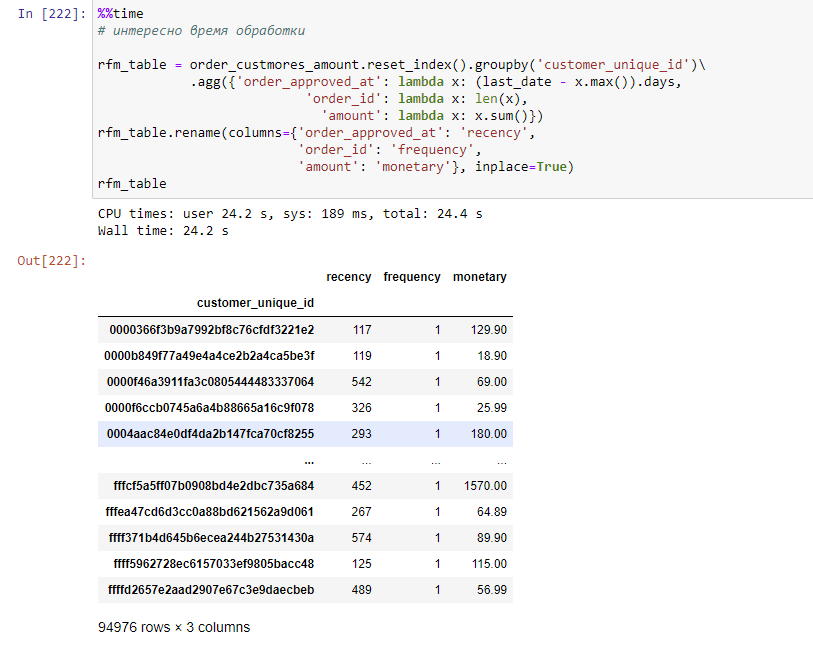

##### Посмотрим на распределение наших данных

In [70]:
rfm_table.describe()

,recency,frequency,monetary
count,94976.000000,94976.000000,94976.000000
mean,243.504180,1.033851,142.085769
std,152.989713,0.210795,216.107543
min,1.000000,1.000000,0.850000
25%,119.000000,1.000000,47.900000
50%,224.000000,1.000000,89.890000
75%,353.000000,1.000000,155.000000
max,719.000000,16.000000,13440.000000


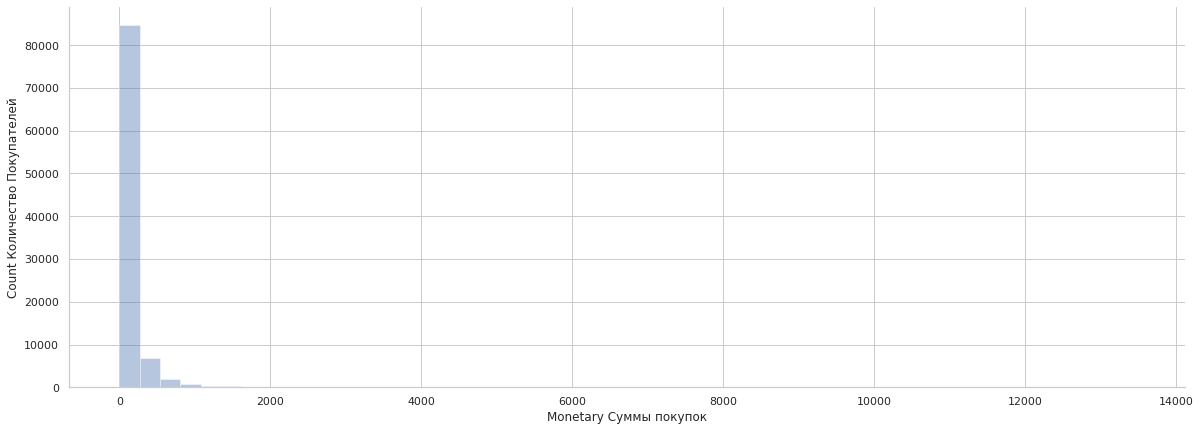

In [71]:
sns.distplot(rfm_table.monetary, kde=False)
plt.xlabel('Monetary Суммы покупок')
plt.ylabel('Count Количество Покупателей')
sns.despine()

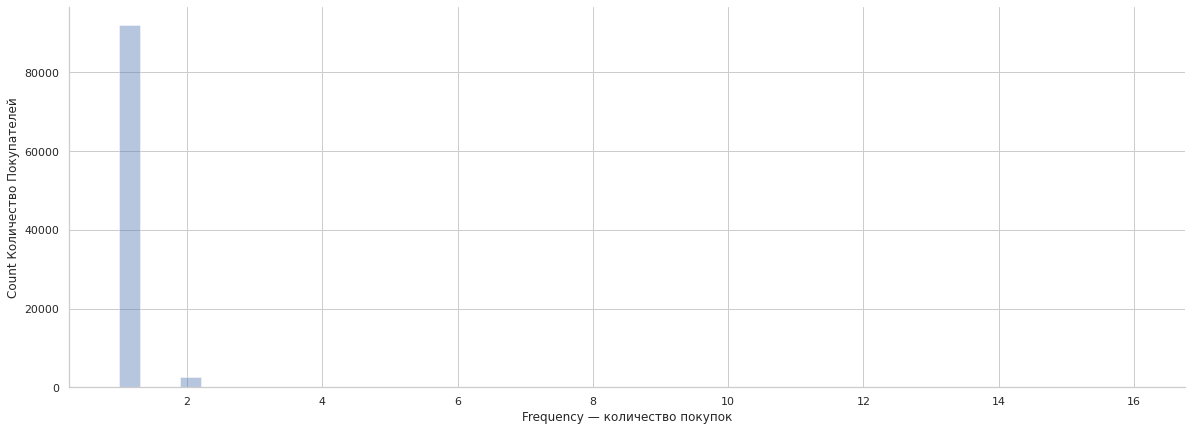

In [72]:
sns.distplot(rfm_table.frequency, kde=False)
plt.xlabel('Frequency — количество покупок')
plt.ylabel('Count Количество Покупателей')
sns.despine()

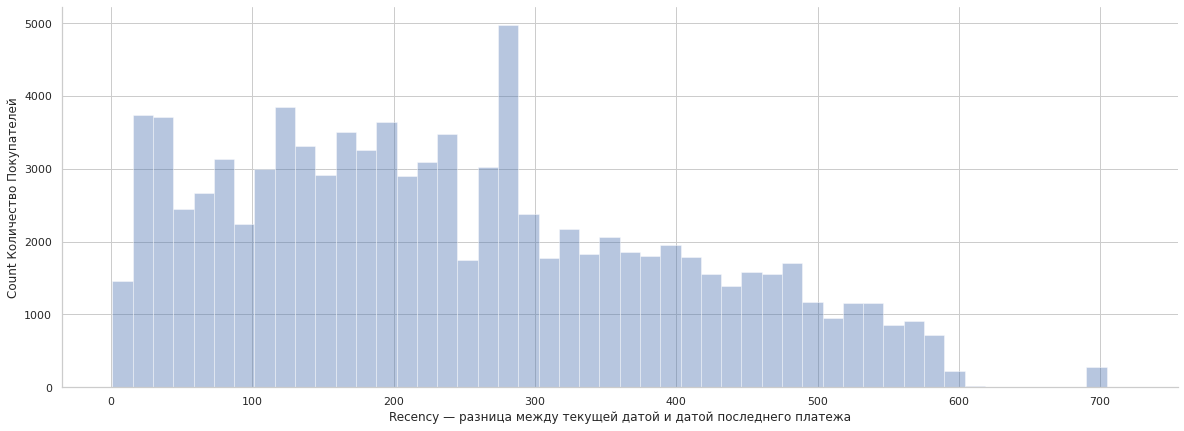

In [73]:
sns.distplot(rfm_table.recency, kde=False)
plt.xlabel('Recency — разница между текущей датой и датой последнего платежа')
plt.ylabel('Count Количество Покупателей')
sns.despine()

### Теперь нам нужно выставить оценки.

очень много данных имеют узкий диапазон мы будем разбивать на диапазон от 1 до 3.

Я собираюсь использовать метод квинтилей. Сначала я получаю квинтили для каждого параметра.

In [74]:
quintiles = rfm_table[['recency', 'frequency', 'monetary']].quantile([.33, .66]).to_dict()
quintiles

{'recency': {0.33: 153.0, 0.66: 292.0},
 'frequency': {0.33: 1.0, 0.66: 1.0},
 'monetary': {0.33: 57.99, 0.66: 124.99}}

Но как мы видим разбивка по квантилям для **frequency** не уместна большинство клиентов совершило только 1 покупку...

In [75]:
rfm_table.frequency.value_counts()

1     92090
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequency, dtype: int64

##### разобьем  frequency на 3 группы:
- 1 - 1 покупка (максимальная группа)
- 2 - 2 покупки (вторая по величине встречаемая группа)
- 3 - более 2 покупок (количество всех остальных значительно меньше первых групп)

In [76]:
quintiles['frequency'] = {0.33: 1.0, 0.66: 2.0}
quintiles

{'recency': {0.33: 153.0, 0.66: 292.0},
 'frequency': {0.33: 1.0, 0.66: 2.0},
 'monetary': {0.33: 57.99, 0.66: 124.99}}

###### Пишем методы для присвоения рангов от 1 до 3. 

Меньшее значение новизны лучше, 

тогда как более высокая частота и денежные значения лучше. Будеть два отдельных метода.

333 - самое хорошее / 111 самое плохое

In [77]:
def r_score(x):
    if x <= quintiles['recency'][.33]:
        return 3
    elif x <= quintiles['recency'][.66]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.33]:
        return 1
    elif x <= quintiles[c][.66]:
        return 2
    else:
        return 3  

##### Теперь все готово чтоб получить оценки R, F и M каждого клиента

In [78]:
rfm_table['R'] = rfm_table['recency'].apply(lambda x: r_score(x))
rfm_table['F'] = rfm_table['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm_table['M'] = rfm_table['monetary'].apply(lambda x: fm_score(x, 'monetary'))
rfm_table['RFM Score'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
rfm_table = rfm_table.reset_index()
rfm_table

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,3,113
...,...,...,...,...,...,...,...,...
94971,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,1,1,3,113
94972,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,2,1,2,212
94973,ffff371b4d645b6ecea244b27531430a,574,1,89.90,1,1,2,112
94974,ffff5962728ec6157033ef9805bacc48,125,1,115.00,3,1,2,312


В итоге  получили 27 сегмента с числовыми значениями распределёнными определённым образом в интервале от 111 до 333 включительно, 

- где первая цифра - **Recency** показатель **“давности”/”свежести”** покупок (3 - покупал недавно менее 154 дней назад, 2 - покупал относительно недавно(154 - 292 дня назад) , 1 - покупал довольно давно(Более 292 дней назад), 

- вторая - **frequency** показатель **“частоты”** (3 - покупал часто(более 2 х раз), 2 - покупал не часто(2 раза), 1 - покупал редко(1 раз)), 

- а третья - **monetary** показатель **“монетарности”/”доходности”** (3 - принёс относительно очень много денег (более 125 у.е. , 2 - принес много денег (58 - 125 у.е.), 1 - принёс мало денег(менее 58 у.е.)).

###### Будем визуализировать сегменты

In [79]:
rfm_graph = rfm_table.groupby('RFM Score', as_index=False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns={'customer_unique_id': 'count_customers'})\
               .sort_values('RFM Score')
rfm_graph.head()

,RFM Score,count_customers
0,111,10501
1,112,10638
2,113,10181
3,121,71
4,122,217


##### количество клиентов по RFM Score

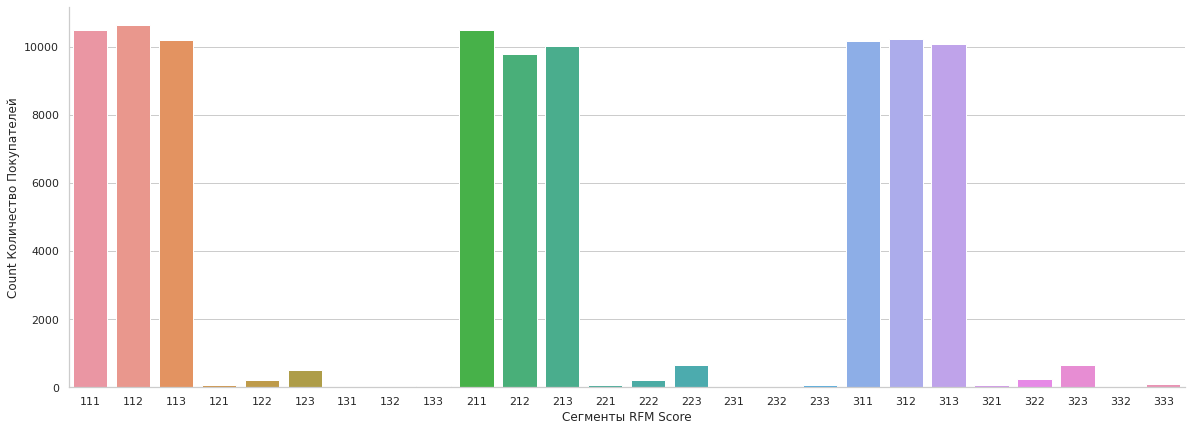

In [80]:
sns.barplot(data=rfm_graph, x='RFM Score', y='count_customers')
plt.xlabel('Сегменты RFM Score')
plt.ylabel('Count Количество Покупателей')
sns.despine()

##### Для удобства и упрощения восприятия некоторые сегменты можно объединять в группы:

- 333 Недавно покупавшие частые с высоким чеком   - **VIP**

- 332 Недавно покупавшие частые со средним чеком  - **Выгодные**

- 331 Недавно покупавшие частые с низким чеком    - **Выгодные**

- 323 Недавно покупавшие редкие с высоким чеком   - **Потенциально выгодные**

- 322 Недавно покупавшие редкие со средним чеком  - **Потенциально выгодные**

- 321 Недавно покупавшие редкие с низким чеком    - **Потенциально выгодныее**

- 313 Недавно покупавшие разовые с высоким чеком  - **Новенькие**

- 312 Недавно покупавшие разовые со средним чеком - **Новенькие**

- 311 Недавно покупавшие разовые с низким чеком   - **Новенькие**

- 233 Спящие частые с высоким чеком               - **Спящие выгодные**

- 232 Спящие частые со средним чеком              - **Спящие выгодные**

- 231 Спящие частые с низким чеком                - **Спящие выгодные**

- 223 Спящие редкие с высоким чеком               - **Спящие выгодные**

- 222 Спящие редкие со средним чеком              - **Спящие выгодные**

- 221 Спящие редкие с низким чеком                - **Спящие**

- 213 Спящие разовые с высоким чеком              - **Спящие**

- 212 Спящие разовые со средним чеком             - **Спящие**

- 211 Спящие разовые с низким чеком               - **Спящие**

- 133 Давние частые с высоким чеком               - **Уходящие выгодные**

- 132 Давние частые со средним чеком              - **Уходящие выгодные**

- 131 Давние частые с низким чеком                - **Уходящие**

- 123 Давние редкие с высоким чеком               - **Уходящие**

- 122 Давние редкие со средним чеком              - **Уходящие**

- 121 Давние редкие с низким чеком                - **Потерянные**

- 113 Давние разовые с высоким чеком              - **Потерянные**

- 112 Давние разовые со средним чеком             - **Потерянные**

- 111 Давние разовые с низким чеком               - **Потерянные**

In [81]:
segt_map = {
    r'333': 'VIP',
    r'33[1-2]': 'Выгодные',
    r'32[1-3]': 'Потенциально выгодные',
    r'31[1-3]': 'Новенькие',
    r'23[1-3]': 'Спящие выгодные',
    r'22[2-3]': 'Спящие выгодные',
    r'21[1-3]': 'Спящие',
    r'221': 'Спящие',
    r'13[2-3]': 'Уходящие выгодные',
    r'12[2-3]': ' Уходящие',
    r'131': ' Уходящие',
    r'11[1-3]': 'Потерянные',
    r'121': 'Потерянные'
}

rfm_table['segment'] = rfm_table['RFM Score'].replace(segt_map, regex=True)
rfm_table.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,3,1,3,313,Новенькие
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,Новенькие
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,Потерянные
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,Потерянные
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,3,113,Потерянные


##### Теперь, когда у нас есть результаты, мы можем выполнить некоторую визуализацию данных, чтобы получить лучшее представление о поведении наших клиентов. Сначала давайте посмотрим на распределение R, F и M.

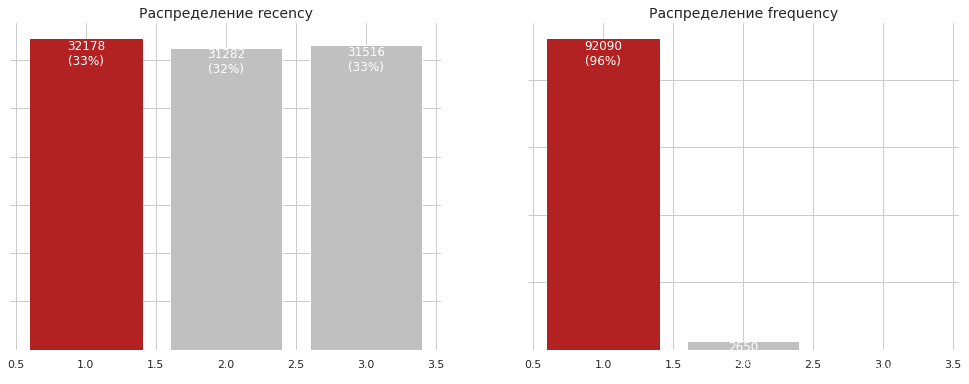

In [82]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'recency', 'F':'frequency'}
    y = rfm_table[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()



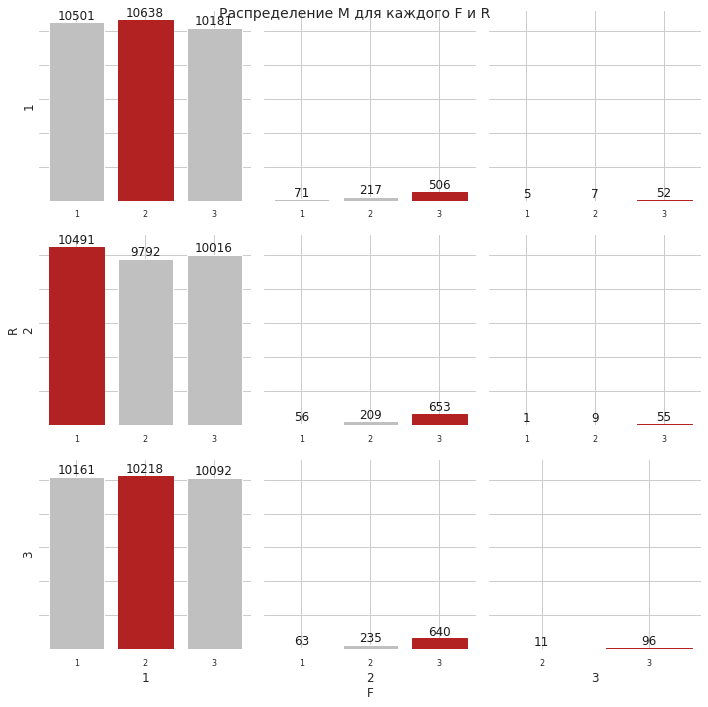

In [83]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = rfm_table[(rfm_table['R'] == r) & (rfm_table['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 3:
            if f == 2:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение M для каждого F и R',
             fontsize=14)
plt.tight_layout()
plt.show()

##### Визуализируем ГРУППЫ

In [84]:
rfm_graph_group = rfm_table.groupby('segment', as_index=False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns={'customer_unique_id': 'count_customers'})
               
rfm_graph_group

,segment,count_customers
0,Уходящие,728
1,VIP,96
2,Выгодные,11
3,Новенькие,30471
4,Потенциально выгодные,938
5,Потерянные,31391
6,Спящие,30355
7,Спящие выгодные,927
8,Уходящие выгодные,59


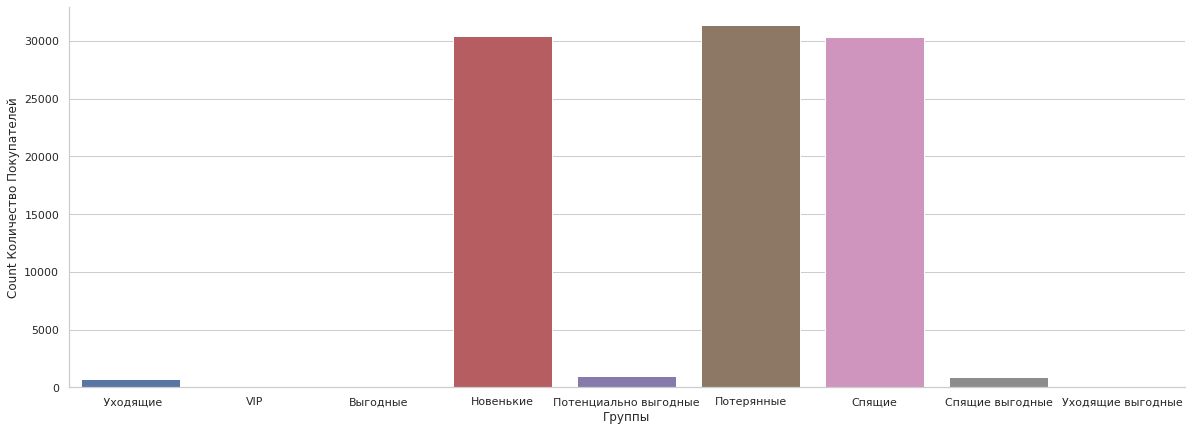

In [85]:
sns.barplot(data=rfm_graph_group, x='segment', y='count_customers')
plt.xlabel('Группы')
plt.ylabel('Count Количество Покупателей')
sns.despine()

##### Сделаем более наглядный график

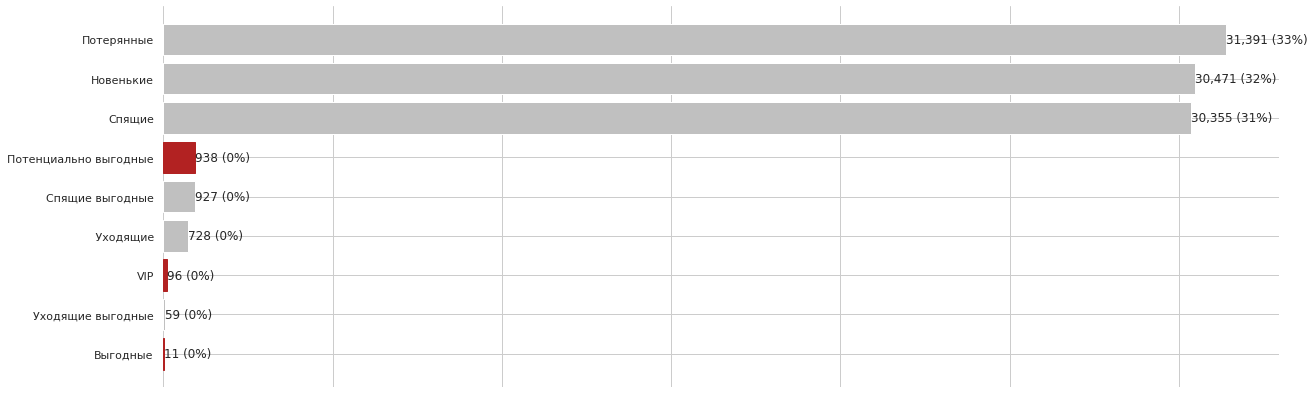

In [86]:
segments_counts = rfm_table['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['VIP', 'Выгодные','Потенциально выгодные']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

###### Василий вот еще суммы покупок  по сегментам

In [87]:
rfm_table.groupby('segment', as_index =False).agg({'monetary':'sum'}).sort_values('monetary', ascending =False)

,segment,monetary
5,Потерянные,4418933.85
3,Новенькие,4297423.25
6,Спящие,4033676.62
7,Спящие выгодные,246420.46
4,Потенциально выгодные,234689.35
0,Уходящие,189844.04
1,VIP,50627.97
8,Уходящие выгодные,22068.11
2,Выгодные,1054.35


##### ОТВЕТ на Вопрос: Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:
- R - время от последней покупки пользователя до текущей даты, 

- F - суммарное количество покупок у пользователя за всё время, 

- M - сумма покупок за всё время. 

Подробно опиши, как ты создавал кластеры. 

**Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.** 


## ОТВЕТ
У нас  31% Клиентов находятся в спящем режиме, 33% теоритически потеряны, Очень мало выгодных.. и большая доля 32% новеньких, 
#### P.S. ВАСИЛИЙ надо обязательно что-то предпринять) потеряем клиентов

In [88]:
pd.to_datetime(datetime.now(), format='%Y-%m-%d')

Timestamp('2022-12-28 09:46:13.944605')

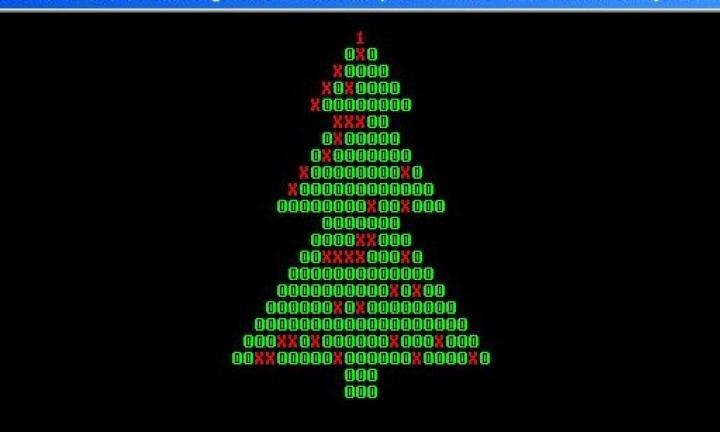

# @SUPPORT
## С Наступающим Новым Годом))

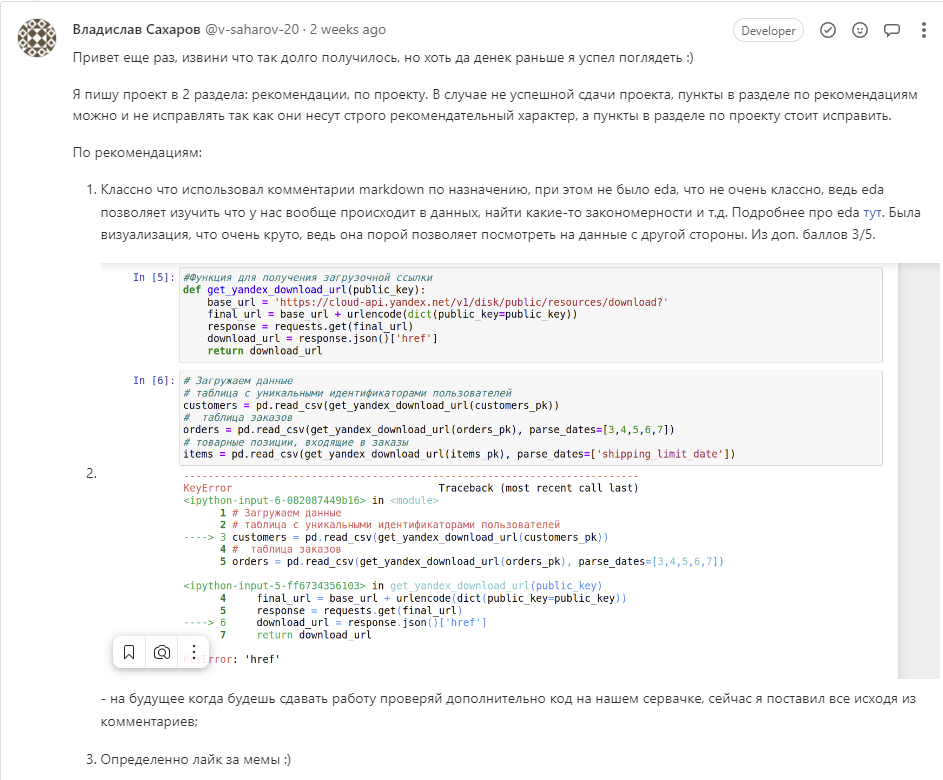

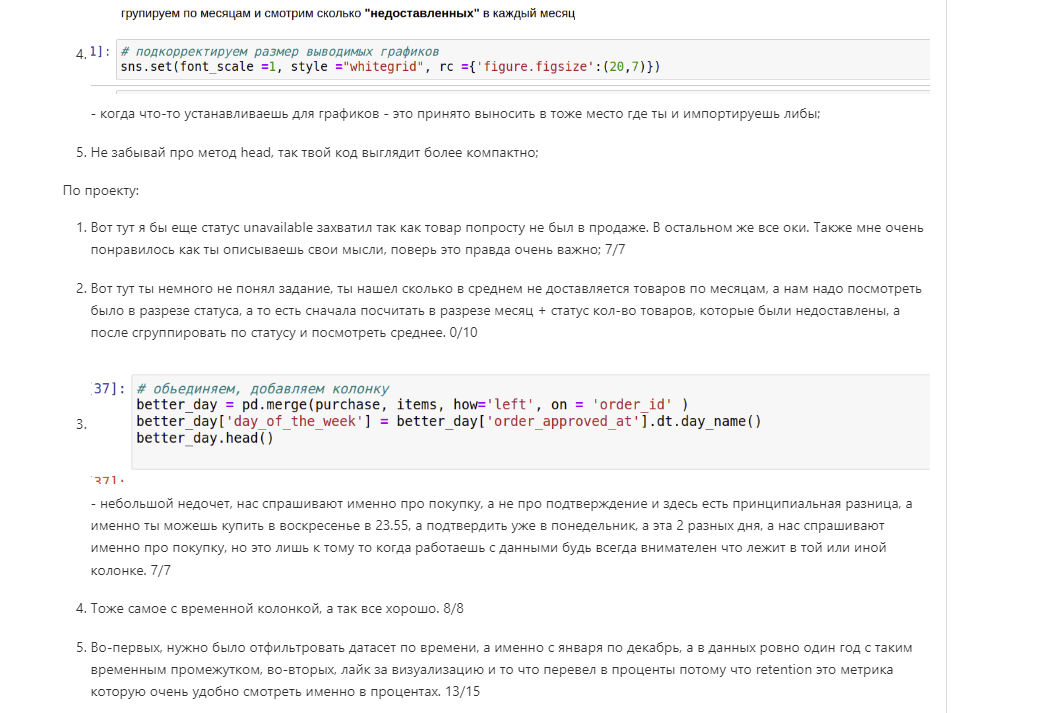

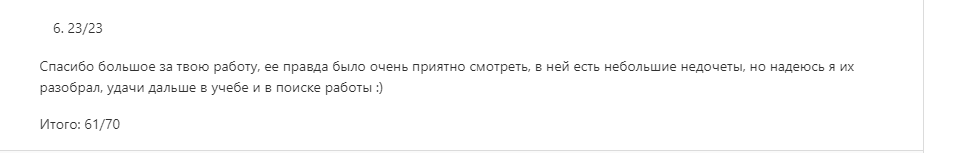